In [1]:
#####################
# Train & Eval
#####################

# coding=utf-8
# Copyright 2021 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lint as: python3
"""Trains TFT based on a defined set of parameters.
Uses default parameters supplied from the configs file to train a TFT model from
scratch.

Usage:
python3 script_train_fixed_params {expt_name} {output_folder}

Command line args:
  expt_name: Name of dataset/experiment to train.
  output_folder: Root folder in which experiment is saved
"""

import argparse
import datetime as dte
import os,sys
sys.path.append('/tf/crypto_prediction_ml_dl/script')
sys.path.append('/tf/crypto_prediction_ml_dl/notebook/TFT_models')

import data_formatters.base
import expt_settings.configs
import libs.hyperparam_opt
import libs.tft_model
import libs.utils as utils
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf

import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

ExperimentConfig = expt_settings.configs.ExperimentConfig
HyperparamOptManager = libs.hyperparam_opt.HyperparamOptManager
ModelClass = libs.tft_model.TemporalFusionTransformer
tf.experimental.output_all_intermediates(True)

2023-11-20 13:10:45.990411: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-20 13:10:46.016286: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-11-20 13:10:47.004142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 13:10:47.007868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 13:10:47.007985: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
def main_train(expt_name,
         use_gpu,
         model_folder,
         data_csv_path,
         data_formatter,
         use_testing_mode=False):
    """Trains tft based on defined model params.

    Args:
      expt_name: Name of experiment
      use_gpu: Whether to run tensorflow with GPU operations
      model_folder: Folder path where models are serialized
      data_csv_path: Path to csv file containing data
      data_formatter: Dataset-specific data fromatter (see
        expt_settings.dataformatter.GenericDataFormatter)
      use_testing_mode: Uses a smaller models and data sizes for testing purposes
        only -- switch to False to use original default settings
    """

    num_repeats = 1

    if not isinstance(data_formatter, data_formatters.base.GenericDataFormatter):
        raise ValueError(
            "Data formatters should inherit from" +
            "AbstractDataFormatter! Type={}".format(type(data_formatter)))

    # Tensorflow setup
    default_keras_session = tf.keras.backend.get_session()

    if use_gpu:
        tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id=0)

    else:
        tf_config = utils.get_default_tensorflow_config(tf_device="cpu")

    print("*** Training from defined parameters for {} ***".format(expt_name))

    print("Loading & splitting data...")
    raw_data = pd.read_csv(data_csv_path, index_col=0)
    train, valid, test = data_formatter.split_data(raw_data)
    train_samples, valid_samples = data_formatter.get_num_samples_for_calibration()

    # Sets up default params
    fixed_params = data_formatter.get_experiment_params()
    params = data_formatter.get_default_model_params()
    params["model_folder"] = model_folder

    # Parameter overrides for testing only! Small sizes used to speed up script.
    if use_testing_mode:
        fixed_params["num_epochs"] = 1
        params["hidden_layer_size"] = 5
        train_samples, valid_samples = 100, 10

    # Sets up hyperparam manager
    print("*** Loading hyperparm manager ***")
    opt_manager = HyperparamOptManager({k: [params[k]] for k in params},
                                       fixed_params, model_folder)


    # Training -- one iteration only
    print("*** Running calibration ***")
    print("Params Selected:")
    for k in params:
        print("{}: {}".format(k, params[k]))

    best_loss = np.Inf
    for _ in range(num_repeats):

        tf.reset_default_graph()
        with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:

            tf.keras.backend.set_session(sess)

            params = opt_manager.get_next_parameters()
            model = ModelClass(params, use_cudnn=use_gpu)

            if not model.training_data_cached():
                model.cache_batched_data(train, "train", num_samples=train_samples)
                model.cache_batched_data(valid, "valid", num_samples=valid_samples)

            sess.run(tf.global_variables_initializer())
            model.fit()

            val_loss = model.evaluate()

            if val_loss < best_loss:
                opt_manager.update_score(params, val_loss, model)
                best_loss = val_loss

            tf.keras.backend.set_session(default_keras_session)

    print("*** Running tests ***")
    tf.reset_default_graph()
    with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:
        tf.keras.backend.set_session(sess)
        best_params = opt_manager.get_best_params()
        model = ModelClass(best_params, use_cudnn=use_gpu)

        model.load(opt_manager.hyperparam_folder)

        print("Computing best validation loss")
        val_loss = model.evaluate(valid)

        print("Computing test loss")
        output_map = model.predict(test, return_targets=True)
        targets = data_formatter.format_predictions(output_map["targets"])
        p50_forecast = data_formatter.format_predictions(output_map["p50"])
        p90_forecast = data_formatter.format_predictions(output_map["p90"])

        def extract_numerical_data(data):
            """Strips out forecast time and identifier columns."""
            return data[[
                col for col in data.columns
                if col not in {"forecast_time", "identifier"}
            ]]

        p50_loss = utils.numpy_normalised_quantile_loss(
            extract_numerical_data(targets), extract_numerical_data(p50_forecast), 0.5)
        p90_loss = utils.numpy_normalised_quantile_loss(
            extract_numerical_data(targets), extract_numerical_data(p90_forecast), 0.9)

        tf.keras.backend.set_session(default_keras_session)

    print("Training completed @ {}".format(dte.datetime.now()))
    print("Best validation loss = {}".format(val_loss))
    print("Params:")

    for k in best_params:
        print(k, " = ", best_params[k])
    print()
    print("Normalised Quantile Loss for Test Data: P50={}, P90={}".format(
        p50_loss.mean(), p90_loss.mean()))
    
    return output_map



In [5]:
dataset_name = 'crypto_day_all'
output_folder = '.'
use_tensorflow_with_gpu = 'yes'

print("Using output folder {}".format(output_folder))

config = ExperimentConfig(dataset_name, output_folder)
formatter = config.make_data_formatter()

# Customise inputs to main() for new datasets.
output_map = main_train(
    expt_name=dataset_name,
    use_gpu=use_tensorflow_with_gpu,
    model_folder=os.path.join(config.model_folder, "fixed"),
    data_csv_path=config.data_csv_path,
    data_formatter=formatter,
    use_testing_mode=False)  # Change to false to use original default params

Using output folder .
Selecting GPU ID=0
*** Training from defined parameters for crypto_day_all ***
Loading & splitting data...
Formatting train-valid-test splits.
Setting scalers with training data...
*** Loading hyperparm manager ***
*** Running calibration ***
Params Selected:
dropout_rate: 0.3
hidden_layer_size: 160
learning_rate: 0.01
minibatch_size: 32
max_gradient_norm: 0.01
num_heads: 1
stack_size: 1
model_folder: ./saved_models/crypto_day_all/fixed
Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.3
# hidden_layer_size = 160
# learning_rate = 0.01
# max_gradient_norm = 0.01
# minibatch_size = 32
# model_folder = ./saved_models/crypto_day_all/fixed
# num_heads = 1
# stack_size = 1
# total_time_steps = 37
# num_encoder_steps = 30
# num_epochs = 100
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('btc_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('btc_dt', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), 

2023-11-20 13:12:30.660538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 13:12:30.660827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 13:12:30.661028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-11-20 13:12:31.129750: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_7/bias/Assign' id:346 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_7/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_7/bias, TemporalFusionTransformer/time_distributed_7/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:12:31.136116: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_11/stack_1' id:359 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_11/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type:

2023-11-20 13:12:31.335628: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_18/stack_2' id:633 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_18/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:12:31.359331: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_15/bias/Assign' id:658 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_15/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_15/bias, TemporalFusionTransformer/time_d

2023-11-20 13:12:31.545660: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_24/stack_1' id:866 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_24/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 0 23>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:12:31.552703: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_24/stack_2' id:867 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_24/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutati

2023-11-20 13:12:31.988608: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_28/kernel/Assign' id:1160 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_28/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_28/kernel, TemporalFusionTransformer/time_distributed_28/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:12:32.001572: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_32/stack_1' id:1179 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_32/stack_1}} = Const[_has_manual_control_dependencies=true, d

2023-11-20 13:12:32.620244: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_35/stack' id:1226 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_35/stack}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 0 0 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:12:32.641461: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_35/stack_1' id:1227 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_35/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 0 30 0>]()}}' was changed by setting attribute after it was run by a session. This muta

2023-11-20 13:12:33.328971: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_45/kernel/Assign' id:3004 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_45/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_45/kernel, TemporalFusionTransformer/time_distributed_45/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:12:33.377596: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_41/stack_1' id:3138 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_41/stack_1}} = Const[_has_manual_control_dependencies=true, d

2023-11-20 13:12:34.440476: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_46/stack_1' id:4103 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_46/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 0 9>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:12:34.484359: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_46/stack_2' id:4104 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_46/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutat

2023-11-20 13:12:35.678354: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_87/bias/Assign' id:5006 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_87/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_87/bias, TemporalFusionTransformer/time_distributed_87/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:12:35.761905: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_51/stack_1' id:5068 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_51/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor

2023-11-20 13:12:37.334390: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_24/gamma/Assign' id:5989 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_24/gamma/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_24/gamma, TemporalFusionTransformer/layer_normalization_24/gamma/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:12:37.432883: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_56/stack_1' id:6033 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_56/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT3

2023-11-20 13:12:39.275012: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_124/kernel/Assign' id:6834 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_124/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_124/kernel, TemporalFusionTransformer/time_distributed_124/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:12:39.411531: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_61/stack_1' id:6998 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_61/stack_1}} = Const[_has_manual_control_dependencies=tru

2023-11-20 13:12:41.311205: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_65/stack_2' id:7771 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_65/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:12:41.545815: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_146/bias/Assign' id:7872 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_146/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_146/bias, TemporalFusionTransformer/t

2023-11-20 13:12:43.474579: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_161/kernel/Assign' id:8539 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_161/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_161/kernel, TemporalFusionTransformer/time_distributed_161/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:12:43.618678: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_68/stack_1' id:8609 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_68/stack_1}} = Const[_has_manual_control_dependencies=tru

2023-11-20 13:12:46.049261: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/eye/diag/num_rows' id:9492 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/eye/diag/num_rows}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: -1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:12:46.172147: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/eye/diag/num_cols' id:9493 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/eye/diag/num_cols}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: -1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and wil

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 37, 31)]             0         []                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 37, 31)]             0         ['input_1[0][0]']             
 Transformer/strided_slice                                                                        
 (TensorFlowOpLayer)                                                                              
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1)]                  0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0]

 Transformer/concat_1/conca                                         ]                             
 t (TensorFlowOpLayer)                                                                            
                                                                                                  
 multiply_2 (Multiply)       (None, 1, 160)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims[0][0]',  
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_1/concat[0][0
                                                                    ]']                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 160)]                0         ['multiply_2[0][0]']          
 Transform

                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 37, 1)]              0         ['tf_op_layer_TemporalFusionTr


2023-11-20 13:12:48.000889: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_75/stack_2' id:10120 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_75/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


 Transformer/strided_slice_                                         ansformer/strided_slice[0][0]'
 20 (TensorFlowOpLayer)                                             ]                             
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 37, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0][0]'
 21 (TensorFlowOpLayer)                                             ]                             
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 37, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0][0]'
 22 (TensorFlowOpLayer)                                             ]                             
          

                                                                    0]']                          
                                                                                                  
 time_distributed_8 (TimeDi  (None, 37, 160)              320       ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_11[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_9 (TimeDi  (None, 37, 160)              320       ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_12[0][
                                                                    0]']                          
                                                                                                  
 time_dist

 istributed)                                                        ansformer/strided_slice_31[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_29 (TimeD  (None, 37, 160)              320       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_32[0][
                                                                    0]']                          
                                                                                                  
 time_distributed (TimeDist  (None, 37, 160)              320       ['tf_op_layer_TemporalFusionTr
 ributed)                                                           ansformer/strided_slice_3[0][0
                                                                    ]']                           
          

                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 4800)]           0         ['tf_op_layer_TemporalFusionTr
 Transformer/Reshape (Tenso                                         ansformer/concat[0][0]']      
 rFlowOpLayer)                                                                                    
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 160)]             0         ['layer_normalization_2[0][0]'
 Transformer/ExpandDims_1 (                                         ]                             
 TensorFlowOpLayer)                                                                               
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 7, 160, 1)]          0         ['tf_op_layer_TemporalFusionTr
 Transform

 tf_op_layer_TemporalFusion  [(None, 30, 160)]            0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 51 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160)]            0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 52 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160)]            0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 53 (Tenso

                                                                    0]']                          
                                                                                                  
 time_distributed_44 (TimeD  (None, 30, 160)              25760     ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_40[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_48 (TimeD  (None, 30, 160)              25760     ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_41[0][
                                                                    0]']                          
                                                                                                  
 time_dist

 Distributed)                                                       ansformer/strided_slice_60[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_128 (Time  (None, 30, 160)              25760     ['tf_op_layer_TemporalFusionTr
 Distributed)                                                       ansformer/strided_slice_61[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_132 (Time  (None, 30, 160)              25760     ['tf_op_layer_TemporalFusionTr
 Distributed)                                                       ansformer/strided_slice_62[0][
                                                                    0]']                          
          

                                                                                                  
 activation_30 (Activation)  (None, 30, 160)              0         ['time_distributed_120[0][0]']
                                                                                                  
 activation_31 (Activation)  (None, 30, 160)              0         ['time_distributed_124[0][0]']
                                                                                                  
 activation_32 (Activation)  (None, 30, 160)              0         ['time_distributed_128[0][0]']
                                                                                                  
 activation_33 (Activation)  (None, 30, 160)              0         ['time_distributed_132[0][0]']
                                                                                                  
 activation_34 (Activation)  (None, 30, 160)              0         ['time_distributed_136[0][0]']
          

 Distributed)                                                                                     
                                                                                                  
 time_distributed_113 (Time  (None, 30, 160)              25760     ['activation_28[0][0]']       
 Distributed)                                                                                     
                                                                                                  
 time_distributed_117 (Time  (None, 30, 160)              25760     ['activation_29[0][0]']       
 Distributed)                                                                                     
                                                                                                  
 time_distributed_121 (Time  (None, 30, 160)              25760     ['activation_30[0][0]']       
 Distributed)                                                                                     
          

                                                                                                  
 dropout_26 (Dropout)        (None, 30, 160)              0         ['time_distributed_113[0][0]']
                                                                                                  
 dropout_27 (Dropout)        (None, 30, 160)              0         ['time_distributed_117[0][0]']
                                                                                                  
 dropout_28 (Dropout)        (None, 30, 160)              0         ['time_distributed_121[0][0]']
                                                                                                  
 dropout_29 (Dropout)        (None, 30, 160)              0         ['time_distributed_125[0][0]']
                                                                                                  
 dropout_30 (Dropout)        (None, 30, 160)              0         ['time_distributed_129[0][0]']
          

 istributed)                                                                                      
                                                                                                  
 time_distributed_67 (TimeD  (None, 30, 160)              25760     ['dropout_14[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_70 (TimeD  (None, 30, 160)              25760     ['dropout_15[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_71 (TimeD  (None, 30, 160)              25760     ['dropout_15[0][0]']          
 istributed)                                                                                      
          

 time_distributed_122 (Time  (None, 30, 160)              25760     ['dropout_28[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 time_distributed_123 (Time  (None, 30, 160)              25760     ['dropout_28[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 time_distributed_126 (Time  (None, 30, 160)              25760     ['dropout_29[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 time_distributed_127 (Time  (None, 30, 160)              25760     ['dropout_29[0][0]']          
 Distribut

                                                                                                  
 multiply_13 (Multiply)      (None, 30, 160)              0         ['time_distributed_58[0][0]', 
                                                                     'time_distributed_59[0][0]'] 
                                                                                                  
 multiply_14 (Multiply)      (None, 30, 160)              0         ['time_distributed_62[0][0]', 
                                                                     'time_distributed_63[0][0]'] 
                                                                                                  
 multiply_15 (Multiply)      (None, 30, 160)              0         ['time_distributed_66[0][0]', 
                                                                     'time_distributed_67[0][0]'] 
                                                                                                  
 multiply_

 multiply_39 (Multiply)      (None, 7, 1)                 0         ['time_distributed_160[0][0]',
                                                                     'time_distributed_161[0][0]']
                                                                                                  
 time_distributed_164 (Time  (None, 7, 160)               25760     ['dropout_38[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 time_distributed_165 (Time  (None, 7, 160)               25760     ['dropout_38[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 layer_normalization_6 (Lay  (None, 30, 30)               60        ['add_6[0][0]']               
 erNormali

                                                                    ansformer/strided_slice_52[0][
                                                                    0]',                          
                                                                     'multiply_22[0][0]']         
                                                                                                  
 add_22 (Add)                (None, 30, 160)              0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_53[0][
                                                                    0]',                          
                                                                     'multiply_23[0][0]']         
                                                                                                  
 add_23 (Add)                (None, 30, 160)              0         ['tf_op_layer_TemporalFusionTr
          

 add_37 (Add)                (None, 7, 1)                 0         ['time_distributed_156[0][0]',
                                                                     'multiply_39[0][0]']         
                                                                                                  
 multiply_40 (Multiply)      (None, 7, 160)               0         ['time_distributed_164[0][0]',
                                                                     'time_distributed_165[0][0]']
                                                                                                  
 activation_8 (Activation)   (None, 30, 30)               0         ['layer_normalization_6[0][0]'
                                                                    ]                             
                                                                                                  
 layer_normalization_7 (Lay  (None, 30, 160)              320       ['add_7[0][0]']               
 erNormali

                                                                                                  
 layer_normalization_32 (La  (None, 30, 160)              320       ['add_32[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_normalization_33 (La  (None, 30, 160)              320       ['add_33[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_normalization_34 (La  (None, 30, 160)              320       ['add_34[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_nor

                                                                    ',                            
                                                                     'layer_normalization_32[0][0]
                                                                    ',                            
                                                                     'layer_normalization_33[0][0]
                                                                    ',                            
                                                                     'layer_normalization_34[0][0]
                                                                    ',                            
                                                                     'layer_normalization_35[0][0]
                                                                    ',                            
                                                                     'layer_normalization_36[0][0]
          

 Transformer/concat_2 (Tens                                          'cu_dnnlstm_1[0][0]']        
 orFlowOpLayer)                                                                                   
                                                                                                  
 dropout_3 (Dropout)         (None, 160)                  0         ['dense_45[0][0]']            
                                                                                                  
 dropout_39 (Dropout)        (None, 37, 160)              0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_2[0][0]']    
                                                                                                  
 dense_46 (Dense)            (None, 160)                  25760     ['dropout_3[0][0]']           
                                                                                                  
 dense_47 

 lowOpLayer)                                                                                      
                                                                                                  
 tf_op_layer_TemporalFusion  [()]                         0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/Shape[0][0]']       
 69 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(3,)]                       0         ['layer_normalization_40[0][0]
 Transformer/Shape_1 (Tenso                                         ']                            
 rFlowOpLayer)                                                                                    
                                                                                                  
 tf_op_lay

 multiply_44 (Multiply)      (None, 37, 160)              0         ['time_distributed_173[0][0]',
                                                                     'time_distributed_174[0][0]']
                                                                                                  
 add_42 (Add)                (None, 37, 160)              0         ['multiply_44[0][0]',         
                                                                     'layer_normalization_40[0][0]
                                                                    ']                            
                                                                                                  
 layer_normalization_41 (La  (None, 37, 160)              320       ['add_42[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 time_dist

2023-11-20 13:12:48.647445: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_43/beta/Assign' id:10068 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_43/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_43/beta, TemporalFusionTransformer/layer_normalization_43/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


*** Fitting TemporalFusionTransformer ***
Getting batched_data
Using cached training data
Using cached validation data
Using keras standard fit
Train on 864 samples, validate on 101 samples
Epoch 1/100


2023-11-20 13:12:53.045578: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:10260 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_181_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:12:53.872154: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/TemporalFusionTransformer/time_distributed_147/bias/m/Assign' id:17125 op device:{requested: '', assigned: ''} def:{{{node training/Adam/TemporalFusionTransformer/time_distributed_147/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/TemporalFusionTransf

832/864 [===========================>..] - ETA: 0s - loss: 1.3798

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-20 13:13:00.520139: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:10260 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_181_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


864/864 [==============================] - 11s 13ms/sample - loss: 1.3449 - val_loss: 0.5611
Epoch 2/100
864/864 [==============================] - 1s 2ms/sample - loss: 0.2870 - val_loss: 0.2843
Epoch 3/100
864/864 [==============================] - 1s 2ms/sample - loss: 0.1949 - val_loss: 0.1532
Epoch 4/100
864/864 [==============================] - 1s 2ms/sample - loss: 0.1642 - val_loss: 0.0744
Epoch 5/100
864/864 [==============================] - 1s 1ms/sample - loss: 0.1737 - val_loss: 0.0886
Epoch 6/100
864/864 [==============================] - 1s 1ms/sample - loss: 0.1530 - val_loss: 0.0877
Epoch 7/100
864/864 [==============================] - 1s 1ms/sample - loss: 0.1470 - val_loss: 0.0839
Epoch 8/100
864/864 [==============================] - 2s 2ms/sample - loss: 0.1331 - val_loss: 0.0694
Epoch 9/100
864/864 [==============================] - 1s 2ms/sample - loss: 0.1519 - val_loss: 0.0506
Epoch 10/100
864/864 [==============================] - 1s 1ms/sample - loss: 0.139

2023-11-20 13:13:22.939642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 13:13:22.940566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 13:13:22.941121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-11-20 13:13:23.152207: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_6/bias/Assign' id:307 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_6/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_6/bias, TemporalFusionTransformer/time_distributed_6/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:13:23.160286: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_10/stack_1' id:320 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_10/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type:

2023-11-20 13:13:23.358369: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_12/bias/Assign' id:541 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_12/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_12/bias, TemporalFusionTransformer/time_distributed_12/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:13:23.369322: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_16/stack_1' id:554 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_16/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<t

2023-11-20 13:13:23.578183: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_17/bias/Assign' id:736 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_17/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_17/bias, TemporalFusionTransformer/time_distributed_17/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:13:23.591119: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_21/stack_1' id:749 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_21/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<t

2023-11-20 13:13:24.009937: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_25/kernel/Assign' id:1043 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_25/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_25/kernel, TemporalFusionTransformer/time_distributed_25/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:13:24.026959: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_29/stack_1' id:1061 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_29/stack_1}} = Const[_has_manual_control_dependencies=true, d

2023-11-20 13:13:24.419653: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/ExpandDims/dim' id:1410 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/ExpandDims/dim}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: -1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:13:24.443282: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/dense_36/kernel/Assign' id:1446 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/dense_36/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/dense_36/kernel, TemporalFusionTransformer/dense_36/kernel/Initializer/stateless_random_uniform)

2023-11-20 13:13:25.141199: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_35/bias/Assign' id:2495 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_35/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_35/bias, TemporalFusionTransformer/time_distributed_35/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:13:25.184167: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_38/stack_1' id:2560 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_38/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor

2023-11-20 13:13:26.000123: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_42/stack_2' id:3332 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_42/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:13:26.119206: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_55/kernel/Assign' id:3457 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_55/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_55/kernel, TemporalFusionTransforme

2023-11-20 13:13:27.174790: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_47/stack_1' id:4296 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_47/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 0 10>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:13:27.225248: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_47/stack_2' id:4297 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_47/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This muta

2023-11-20 13:13:28.562838: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_90/kernel/Assign' id:5165 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_90/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_90/kernel, TemporalFusionTransformer/time_distributed_90/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:13:28.652365: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_52/stack_1' id:5261 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_52/stack_1}} = Const[_has_manual_control_dependencies=true, d

2023-11-20 13:13:30.338527: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_25/beta/Assign' id:6187 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_25/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_25/beta, TemporalFusionTransformer/layer_normalization_25/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:13:30.447764: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_57/stack_1' id:6226 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_57/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, 

2023-11-20 13:13:32.168808: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_61/stack_2' id:6999 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_61/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:13:32.394385: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_30/gamma/Assign' id:7147 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_30/gamma/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_30/gamma, TemporalFusionTran

2023-11-20 13:13:34.522710: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_66/stack_2' id:7964 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_66/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:13:34.778212: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_151/kernel/Assign' id:8089 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_151/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_151/kernel, TemporalFusionTransfo

2023-11-20 13:13:36.866513: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_162/bias/Assign' id:8642 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_162/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_162/bias, TemporalFusionTransformer/time_distributed_162/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:13:37.029363: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/Sum_1/reduction_indices' id:8362 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/Sum_1/reduction_indices}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tens

2023-11-20 13:13:39.440577: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/eye/concat/axis' id:9487 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/eye/concat/axis}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 13:13:39.569240: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_70/stack' id:9481 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_70/stack}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, an

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 37, 31)]             0         []                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 37, 31)]             0         ['input_1[0][0]']             
 Transformer/strided_slice                                                                        
 (TensorFlowOpLayer)                                                                              
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1)]                  0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0]

 Transformer/concat_1/conca                                         ]                             
 t (TensorFlowOpLayer)                                                                            
                                                                                                  
 multiply_2 (Multiply)       (None, 1, 160)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims[0][0]',  
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_1/concat[0][0
                                                                    ]']                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 160)]                0         ['multiply_2[0][0]']          
 Transform

                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 37, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0][0]'
 20 (TensorFlowOpLayer)                                             ]                             
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 37, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0][0]'
 21 (TensorFlowOpLayer)                                             ]                             
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 37, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transform

2023-11-20 13:13:41.328020: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_75/stack_2' id:10120 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_75/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


 3 (TensorFlowOpLayer)                                              ]                             
                                                                                                  
 dropout_2 (Dropout)         (None, 160)                  0         ['dense_41[0][0]']            
                                                                                                  
 time_distributed_1 (TimeDi  (None, 37, 160)              320       ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_4[0][0
                                                                    ]']                           
                                                                                                  
 time_distributed_2 (TimeDi  (None, 37, 160)              320       ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_5[0][0
          

                                                                                                  
 time_distributed_21 (TimeD  (None, 37, 160)              320       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_24[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_22 (TimeD  (None, 37, 160)              320       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_25[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_23 (TimeD  (None, 37, 160)              320       ['tf_op_layer_TemporalFusionTr
 istribute

                                                                     'dense_43[0][0]']            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160, 28)]        0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/stack_2[0][0]']     
 33 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160, 1)]         0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/stack_3[0][0]']     
 34 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_lay

 43 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160)]            0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 44 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160)]            0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 45 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_lay

 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 64 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160)]            0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 65 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160)]            0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 66 (TensorFlowOpLayer)                                                                           
          

                                                                                                  
 time_distributed_96 (TimeD  (None, 30, 160)              25760     ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_53[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_100 (Time  (None, 30, 160)              25760     ['tf_op_layer_TemporalFusionTr
 Distributed)                                                       ansformer/strided_slice_54[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_104 (Time  (None, 30, 160)              25760     ['tf_op_layer_TemporalFusionTr
 Distribut

                                                                                                  
 activation_15 (Activation)  (None, 30, 160)              0         ['time_distributed_60[0][0]'] 
                                                                                                  
 activation_16 (Activation)  (None, 30, 160)              0         ['time_distributed_64[0][0]'] 
                                                                                                  
 activation_17 (Activation)  (None, 30, 160)              0         ['time_distributed_68[0][0]'] 
                                                                                                  
 activation_18 (Activation)  (None, 30, 160)              0         ['time_distributed_72[0][0]'] 
                                                                                                  
 activation_19 (Activation)  (None, 30, 160)              0         ['time_distributed_76[0][0]'] 
          

 istributed)                                                                                      
                                                                                                  
 time_distributed_73 (TimeD  (None, 30, 160)              25760     ['activation_18[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_77 (TimeD  (None, 30, 160)              25760     ['activation_19[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_81 (TimeD  (None, 30, 160)              25760     ['activation_20[0][0]']       
 istributed)                                                                                      
          

                                                                                                  
 dropout_11 (Dropout)        (None, 30, 160)              0         ['time_distributed_53[0][0]'] 
                                                                                                  
 dropout_12 (Dropout)        (None, 30, 160)              0         ['time_distributed_57[0][0]'] 
                                                                                                  
 dropout_13 (Dropout)        (None, 30, 160)              0         ['time_distributed_61[0][0]'] 
                                                                                                  
 dropout_14 (Dropout)        (None, 30, 160)              0         ['time_distributed_65[0][0]'] 
                                                                                                  
 dropout_15 (Dropout)        (None, 30, 160)              0         ['time_distributed_69[0][0]'] 
          

 istributed)                                                                                      
                                                                                                  
 time_distributed_47 (TimeD  (None, 30, 160)              25760     ['dropout_9[0][0]']           
 istributed)                                                                                      
                                                                                                  
 time_distributed_50 (TimeD  (None, 30, 160)              25760     ['dropout_10[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_51 (TimeD  (None, 30, 160)              25760     ['dropout_10[0][0]']          
 istributed)                                                                                      
          

 time_distributed_102 (Time  (None, 30, 160)              25760     ['dropout_23[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 time_distributed_103 (Time  (None, 30, 160)              25760     ['dropout_23[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 time_distributed_106 (Time  (None, 30, 160)              25760     ['dropout_24[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 time_distributed_107 (Time  (None, 30, 160)              25760     ['dropout_24[0][0]']          
 Distribut

                                                                                                  
 activation_5 (Activation)   (None, 160)                  0         ['dense_48[0][0]']            
                                                                                                  
 activation_6 (Activation)   (None, 160)                  0         ['dense_52[0][0]']            
                                                                                                  
 time_distributed_160 (Time  (None, 7, 1)                 161       ['dropout_37[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 time_distributed_161 (Time  (None, 7, 1)                 161       ['dropout_37[0][0]']          
 Distributed)                                                                                     
          

                                                                     'time_distributed_127[0][0]']
                                                                                                  
 multiply_31 (Multiply)      (None, 30, 160)              0         ['time_distributed_130[0][0]',
                                                                     'time_distributed_131[0][0]']
                                                                                                  
 multiply_32 (Multiply)      (None, 30, 160)              0         ['time_distributed_134[0][0]',
                                                                     'time_distributed_135[0][0]']
                                                                                                  
 multiply_33 (Multiply)      (None, 30, 160)              0         ['time_distributed_138[0][0]',
                                                                     'time_distributed_139[0][0]']
          

                                                                    ansformer/strided_slice_46[0][
                                                                    0]',                          
                                                                     'multiply_16[0][0]']         
                                                                                                  
 add_16 (Add)                (None, 30, 160)              0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_47[0][
                                                                    0]',                          
                                                                     'multiply_17[0][0]']         
                                                                                                  
 add_17 (Add)                (None, 30, 160)              0         ['tf_op_layer_TemporalFusionTr
          

                                                                                                  
 add_32 (Add)                (None, 30, 160)              0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_63[0][
                                                                    0]',                          
                                                                     'multiply_33[0][0]']         
                                                                                                  
 add_33 (Add)                (None, 30, 160)              0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_64[0][
                                                                    0]',                          
                                                                     'multiply_34[0][0]']         
          

                                                                                                  
 layer_normalization_22 (La  (None, 30, 160)              320       ['add_22[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_normalization_23 (La  (None, 30, 160)              320       ['add_23[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_normalization_24 (La  (None, 30, 160)              320       ['add_24[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_nor

                                                                    ',                            
                                                                     'layer_normalization_17[0][0]
                                                                    ',                            
                                                                     'layer_normalization_18[0][0]
                                                                    ',                            
                                                                     'layer_normalization_19[0][0]
                                                                    ',                            
                                                                     'layer_normalization_20[0][0]
                                                                    ',                            
                                                                     'layer_normalization_21[0][0]
          

 erNormalization)                                                                                 
                                                                                                  
 multiply_41 (Multiply)      (None, 7, 160, 1)            0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims_4[0][0]',
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/stack_5[0][0]']     
                                                                                                  
 dense_44 (Dense)            (None, 160)                  25760     ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/Sum[0][0]']         
                                                                                                  
 cu_dnnlst

 tf_op_layer_TemporalFusion  [(None, 37, 160)]            0         ['time_distributed_168[0][0]',
 Transformer/add_40 (Tensor                                          'time_distributed_169[0][0]']
 FlowOpLayer)                                                                                     
                                                                                                  
 activation_42 (Activation)  (None, 37, 160)              0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/add_40[0][0]']      
                                                                                                  
 time_distributed_170 (Time  (None, 37, 160)              25760     ['activation_42[0][0]']       
 Distributed)                                                                                     
                                                                                                  
 dropout_4

 lambda_1 (Lambda)           (None, 37, 37)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/Cumsum[0][0]']      
                                                                                                  
 add_41 (Add)                (None, 37, 37)               0         ['lambda[0][0]',              
                                                                     'lambda_1[0][0]']            
                                                                                                  
 activation_43 (Activation)  (None, 37, 37)               0         ['add_41[0][0]']              
                                                                                                  
 dropout_41 (Dropout)        (None, 37, 37)               0         ['activation_43[0][0]']       
                                                                                                  
 dense_199

 Transformer/strided_slice_                                         ']                            
 75 (TensorFlowOpLayer)                                                                           
                                                                                                  
 time_distributed_181 (Time  (None, 7, 3)                 483       ['tf_op_layer_TemporalFusionTr
 Distributed)                                                       ansformer/strided_slice_75[0][
                                                                    0]']                          
                                                                                                  
Total params: 5736643 (21.88 MB)
Trainable params: 5736643 (21.88 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________
None


2023-11-20 13:13:41.953481: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_181/bias/Assign' id:10166 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_181/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_181/bias, TemporalFusionTransformer/time_distributed_181/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Loading model from ./saved_models/crypto_day_all/fixed/TemporalFusionTransformer.ckpt
tensor: TemporalFusionTransformer/cu_dnnlstm/bias (float32) [1280]
[-0.02469078 -0.05226649  0.03877133 ...  0.00044146 -0.07963278
 -0.08114569]
tensor: TemporalFusionTransformer/cu_dnnlstm/kernel (float32) [160, 640]
[[ 0.06371462 -0.08991622  0.14097072 ...  0.1333624  -0.00567356
  -0.07916184]
 [ 0.07951203 -0.10778052 -0.00977533 ... -0.07701061  0.15963155
   0.06199287]
 [ 0.017827   -0.01968637  0.00118137 ...  0.16163015 -0.16334559
   0.0339473 ]
 ...
 [-0.01306046 -0.0224028   0.06185414 ...  0.11337998 -0.0349262
   0.00826075]
 [ 0.03183404 -0.12365872 -0.09895162 ...  0.17625485 -0.1843281
   0.06756884]
 [-0.0669601   0.07384394 -0.3034797  ...  0.0152152  -0.18471956
  -0.10324816]]
tensor: TemporalFusionTransformer/cu_dnnlstm/recurrent_kernel (float32) [160, 640]
[[ 0.01494934 -0.00100685  0.11414567 ... -0.03230904  0.08276802
  -0.10219989]
 [ 0.04861908 -0.01293415 -0.01479787 ...

INFO:tensorflow:Restoring parameters from ./saved_models/crypto_day_all/fixed/TemporalFusionTransformer.ckpt
Done.
Computing best validation loss


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-20 13:13:42.747894: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:10260 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_181_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Computing test loss


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-11-20 13:13:43.467846: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_181/Reshape_1' id:10175 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_181/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](TemporalFusionTransformer/time_distributed_181/dense_211/BiasAdd, TemporalFusionTransformer/time_distributed_181/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training completed @ 2023-11-20 13:13:44.270865
Best validation loss = 0.06557944420688223
Params:
dropout_rate  =  0.3
hidden_layer_size  =  160
learning_rate  =  0.01
max_gradient_norm  =  0.01
minibatch_size  =  32
model_folder  =  ./saved_models/crypto_day_all/fixed
num_heads  =  1
stack_size  =  1
total_time_steps  =  37
num_encoder_steps  =  30
num_epochs  =  100
early_stopping_patience  =  5
multiprocessing_workers  =  5
column_definition  =  [('btc_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('btc_dt', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('btc_row_id', <DataTypes.REAL_VALUED: 0>, <InputTypes.STATIC_INPUT: 3>), ('btc_low', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_high', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_open', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('btc_close', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_volume', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED

In [ ]:
output_map

In [6]:
targets = formatter.format_predictions(output_map["targets"])

real_close = pd.DataFrame(targets['forecast_time'])
real_close["real_close"] = targets['t+0']

p10_forecast = formatter.format_predictions(output_map["p10"])
p10_forecast_close = p10_forecast['t+0']

p50_forecast = formatter.format_predictions(output_map["p50"])
p50_forecast_close = p50_forecast['t+0']

p90_forecast = formatter.format_predictions(output_map["p90"])
p90_forecast_close = p90_forecast['t+0']

real_and_pred_results = real_close
real_and_pred_results['p10_forecast_close'] = p10_forecast_close
real_and_pred_results['p50_forecast_close'] = p50_forecast_close
real_and_pred_results['p90_forecast_close'] = p90_forecast_close
real_and_pred_results.set_index(['forecast_time'])

,real_close,p10_forecast_close,p50_forecast_close,p90_forecast_close
forecast_time,,,,
2023-09-19,26573.81,26681.046875,27472.357422,29206.355469
2023-09-20,26578.04,26497.187500,27252.822266,28984.322266
2023-09-21,26567.19,25522.025391,26084.746094,27819.232422
2023-09-22,26246.48,25538.761719,26104.847656,27839.205078
2023-09-23,26303.68,25524.777344,26088.089844,27822.474609
2023-09-24,26218.78,25024.910156,25480.810547,27263.265625
2023-09-25,26367.41,25142.384766,25625.957031,27391.191406
2023-09-26,27017.99,24936.275391,25370.457031,27166.173828
2023-09-27,26906.87,25246.806641,25753.664062,27503.062500


<Axes: >

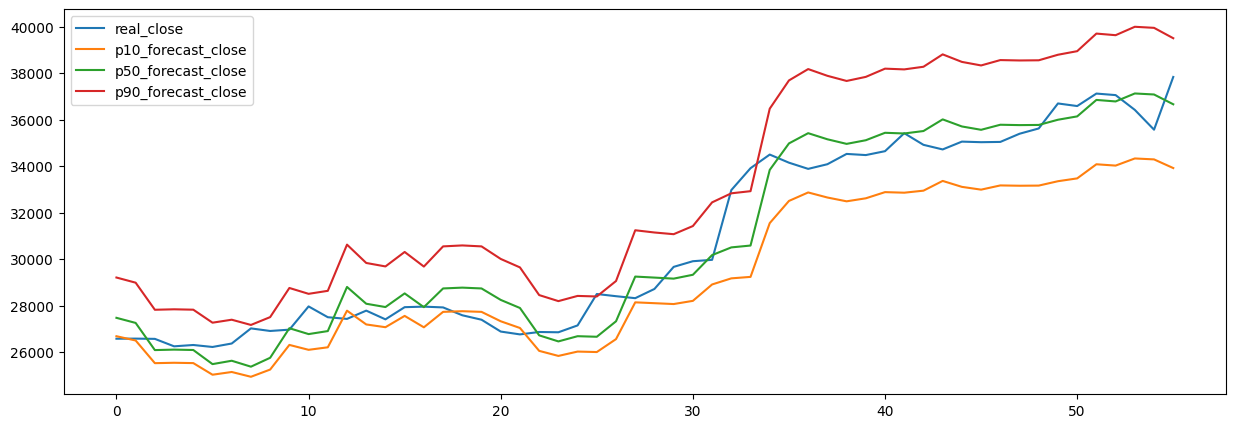

In [7]:
real_and_pred_results.plot(figsize=(15,5))